In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from typing import Union
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import os 

while "notebooks" in os.getcwd():
    os.chdir("..")

from src.preprocessing.lstm.make_dataset import StockReturnsDataset, \
    StockPricesDataset, get_prices_features, normalize_features,\
    generate_sentiment_features

from src.preprocessing.finbert.get_news import get_news, \
    filter_news_with_name, save_company_news_df,\
    read_company_news_df

# LSTM Analysis with Tech stock prices

## Prices

In [3]:
all_prices = pd.DataFrame([])

In [4]:
prices_df = yf.download(
    tickers= "AAPL",
    start="2020-01-10",
    end="2022-12-30",
)

[*********************100%***********************]  1 of 1 completed


In [5]:
universe = [
    "AMZN", 
    "AAPL", 
    "MSFT", 
    "TSLA",
    "META",
    "NFLX",
    "GOOGL",
    "ORCL",
    "ADBE",
    "NVDA"
]
all_prices = []

for ticker in universe:
    prices_df = yf.download(
        tickers= ticker,
        start="2019-12-30",
        end="2023-08-23",
        # end = "2022-12-30"
    )

    all_prices.append(get_prices_features(
        prices_df,
        ticker,
        lookback=10,
        pct_change= False
    ))


all_prices_df = pd.concat(all_prices)

all_prices_df["ticker"] = all_prices_df["ticker"]\
    .replace("META", "FB")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
prices_without_ticker = all_prices_df\
    .loc[:,all_prices_df.columns != 'ticker']

In [7]:
scaler, normalized_prices_df = normalize_features(
    prices_without_ticker
)

In [8]:
normalized_prices_df["ticker"] = all_prices_df["ticker"]

### Obtaining sentiment

In [9]:
universe = [
    "AMZN", 
    "AAPL", 
    "MSFT", 
    "TSLA",
    "FB",
    "NFLX",
    "GOOGL",
    "ORCL",
    "ADBE",
    "NVDA"
]

sentiment_list = []

for ticker in tqdm(universe):
    sentiment = generate_sentiment_features(ticker,
                                            updated= True)
    sentiment["ticker"] = ticker
    sentiment_list.append(sentiment)

sentiment_df = pd.concat(sentiment_list)
sentiment_df.index = pd.to_datetime(sentiment_df.index)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 16.21it/s]


In [10]:
sentiment_df.reset_index(inplace=True)
normalized_prices_df.reset_index(inplace=True)

In [11]:
features_df = pd.merge(
    normalized_prices_df,
    sentiment_df,
    left_on=["ticker", "Date"],
    right_on=["ticker", "date"],
    how = "left"
)\
    .set_index(["Date", "ticker"])

In [12]:
selected_columns = ~((features_df.columns == "index") | (features_df.columns == "date") )

In [13]:
feature_names = [i for i in range(1,10 + 1)]
# feature_names.append("sentiment_count")


In [38]:
train_dates = features_df.index\
    .get_level_values("Date") < '2022-04'

test_dates = (features_df.index\
    .get_level_values("Date") > '2022-04') 

In [39]:
X_train = features_df\
    .loc[train_dates,selected_columns]\
    .fillna(0)

X_test = features_df\
    .loc[test_dates ,selected_columns]\
    .fillna(0)

In [40]:
y_train = features_df\
    .fillna(0)\
    .loc[train_dates, "price"]

y_test = features_df\
    .loc[test_dates, "price"]

In [41]:
X_train_numpy = X_train\
    .loc[:, feature_names]\
    .to_numpy()\
    .reshape((
        X_train.shape[0],
        X_train.loc[:,feature_names].shape[1],
        1
    ))

X_test_numpy = X_test\
    .loc[:, feature_names]\
    .to_numpy()\
    .reshape((
        X_test.shape[0],
        X_test.loc[:,feature_names].shape[1],
        1
    ))

In [42]:
y_train_numpy = y_train\
    .to_numpy()\
    .reshape(-1,1)

y_test_numpy = y_test\
    .to_numpy()\
    .reshape(-1,1)

In [43]:
X_train_tensor = torch\
    .from_numpy(X_train_numpy)\
    .type(torch.Tensor)

X_test_tensor = torch\
    .from_numpy(X_test_numpy)\
    .type(torch.Tensor)

In [44]:
y_train_tensor = torch\
    .from_numpy(y_train_numpy)\
    .type(torch.Tensor)

y_test_tensor = torch\
    .from_numpy(y_test_numpy)\
    .type(torch.Tensor)

In [45]:
dataset = StockPricesDataset(X_train_tensor, y_train_tensor)

dataloader = DataLoader(
    dataset,
    batch_size= 5,
    shuffle= True,
)

In [46]:
X_train_tensor.size(),\
y_train_tensor.size()

(torch.Size([5590, 10, 1]), torch.Size([5590, 1]))

## Building LSTM model

In [47]:
class LSTM(nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 hidden_dim : int , 
                 num_layers : int , 
                 output_dim : int,
                 activation : callable = lambda x : x 
                ):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True,
        )

        self.activation = activation

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, 
                x: torch.Tensor):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.activation(out)
        out = self.fc(out[:, -1, :]) 
        return out

In [48]:
class GRU(nn.Module):
    def __init__(self, 
                 input_dim : int, 
                 hidden_dim : int, 
                 num_layers : int, 
                 output_dim : int
                ):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out


## Neural network training

In [49]:
# lookback = 100
input_dim = 1
hidden_dim = 3
num_layers = 1
output_dim = 1
num_epochs = 100

In [50]:
model = GRU(
    input_dim,
    hidden_dim,
    num_layers,
    output_dim,
)

In [51]:
model.load_state_dict(torch.load("data/models/GRU_sentiment_100_epoch.pt"))

<All keys matched successfully>

In [28]:
treinable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
treinable_params

58

In [29]:
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.05)

In [176]:
# hist = np.zeros(num_epochs)

train_error = []
val_error = []
for t in tqdm(range(num_epochs)):
    epoch_error_train = []
    epoch_error_val = []
    for X, y in (dataloader):
        y_train_pred = model(X)

        loss = loss_fn(y_train_pred, y)
        
        epoch_error_train.append(loss.item())
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    with torch.no_grad():
        y_test_pred = model(X_test_tensor)

        loss = loss_fn(y_test_pred, y_test_tensor)

        epoch_error_val.append(loss.item())

    
    train_error.append(np.mean(epoch_error_train))
    val_error.append(np.mean(epoch_error_val))

        # print(f"Epoch {t+1} error : {np.mean(epoch_accuracy)}")


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


In [52]:
y_pred_test = model(X_test_tensor)\
    .detach()\
    .numpy()

y_pred_train = model(X_train_tensor)\
    .detach()\
    .numpy()

In [53]:
y_pred_test.reshape(-1).shape

(3470,)

In [54]:
y_pred_test = pd.Series(
    y_pred_test\
        .reshape(-1),
    name = "price",
    index = y_test.index      
)

y_pred_train = pd.Series(
    y_pred_train\
        .reshape(-1),
    name = "price",
    index = y_train.index      
)


In [55]:
company_train = y_pred_train\
    .index\
    .get_level_values("ticker") == "AAPL"


company_test = y_pred_test\
    .index\
    .get_level_values("ticker") == "AAPL"

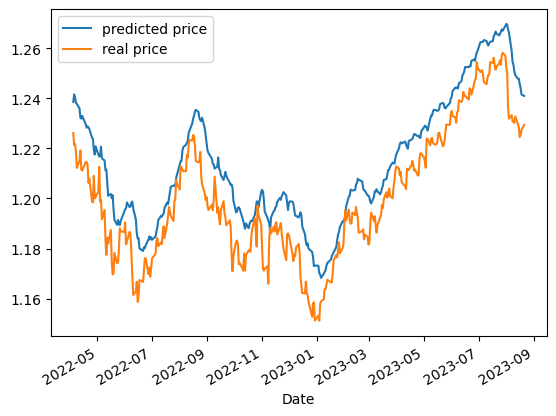

In [56]:
y_pred_test[company_test]\
    .reset_index(level=1)\
    ["price"]\
    .plot(
        label = "predicted price"
    )

y_test[company_test]\
    .reset_index(level=1)\
    ["price"]\
    .plot(
        label = "real price"
    )

# y_test[(y_pred_test.pct_change() < 0 ) & (y_test.index.get_level_values("ticker") == "AAPL")]\
#     .reset_index(level= "ticker")\
#     ["price"]\
#     .plot(
#         label = "buy",
#         marker = "^",
#         linestyle = "None",
#         color = "green"
#     )

# y_test[(y_pred_test.pct_change()>0 ) & (y_test.index.get_level_values("ticker") == "AAPL")]\
#     .reset_index(level= "ticker")\
#     ["price"]\
#     .plot(
#         label = "sell",
#         marker = "^",
#         linestyle = "None",
#         color = "red"
#     )

plt.legend()

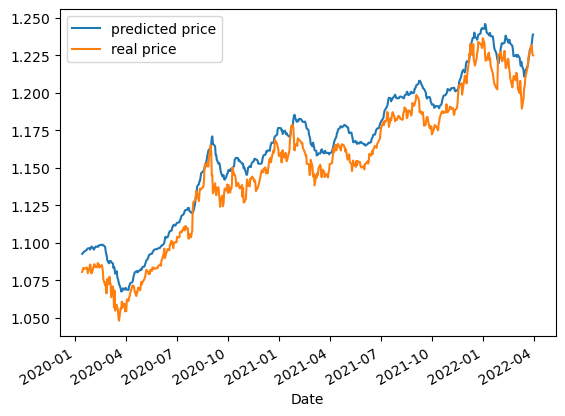

In [57]:
# plt.figure(figsize = (16,10))

y_pred_train[company_train]\
    .reset_index(level= "ticker")\
    ["price"]\
    .plot(
        label = "predicted price",
        # color = "blue"
    )

y_train[company_train]\
    .reset_index(level= "ticker")\
    ["price"]\
    .plot(
        label = "real price",
        # color = "blue"
    )




plt.legend()

## Creating signal

## PnL

In [58]:
y_pred_test.index.get_level_values("Date") > "2023"

array([False, False, False, ...,  True,  True,  True])

In [71]:
mask = positions.rolling(2)\
    .sum() == 0

In [72]:
trades = positions[mask]

In [73]:
trades

Date        ticker
2020-01-28  NVDA      1.0
2020-01-29  NVDA     -1.0
2020-01-30  NVDA      1.0
2020-02-05  NVDA     -1.0
2020-02-24  NVDA      1.0
                     ... 
2022-03-11  NVDA      1.0
2022-03-16  NVDA     -1.0
2022-03-24  NVDA      1.0
2022-03-25  NVDA     -1.0
2022-03-31  NVDA      1.0
Name: position, Length: 181, dtype: float64

In [270]:
num_trades = {}

period = "train"
fees = 5e-4

pnls = {}

for ticker in tqdm(universe):
    if ticker not in ["AMZN", "GOOGL", "AAPL", "MSFT", "FB"]:
        continue
    company_train = y_pred_train\
        .index\
        .get_level_values("ticker") == ticker


    company_test = y_pred_test\
        .index\
        .get_level_values("ticker") == ticker

    assert period in ["train", "val", "test", "full_period"], "period must be one of train, val, test, full_period"
    
    if period == "train":
        y_company = y_train[company_train]\
            .sort_index(level = "Date")
        y_pred_company = y_pred_train[company_train]\
            .sort_index(level = "Date")

    elif period == "full_period":
        y_company = pd.concat([
            y_train[company_train], 
            y_test[company_test]
        ])
        y_pred_company = pd.concat([
            y_pred_train[company_train],
            y_pred_test[company_test]
        ])
        
    else: 
        y_company = y_test[company_test]
        y_pred_company = y_pred_test[company_test]

        if period == "val":
            idx = y_company\
            .index\
            .get_level_values("Date") < "2023"
        
            y_company = y_company[idx]
            y_pred_company = y_pred_company[idx]

        else: # period == "test"
            idx = y_company\
            .index\
            .get_level_values("Date") > "2023"
        
            y_company = y_company[idx]
            y_pred_company = y_pred_company[idx]
        

    avg_price = y_pred_company\
        .pct_change()\
        .rolling(20)\
        .mean()

    std_price = y_pred_company\
        .pct_change()\
        .rolling(20)\
        .std()
    
    zscore = (y_pred_company.pct_change() - avg_price)/std_price

    positions = pd.Series(
        np.nan,
        index = y_pred_company.index,
        name = "position"
    )
    
    positions.loc[y_pred_company.pct_change() < 0]  = 1
    positions.loc[y_pred_company.pct_change() > 0] = -1 


    positions = positions\
        .fillna(0)
    
    num_long = (positions == 1).sum()/positions.shape[0]
    num_short = (positions == -1).sum()/positions.shape[0]
    mask = positions.rolling(2)\
        .sum() == 0
    trades = positions[mask]


    num_trades[ticker] = {
        "num_long" : num_long,
        "num_short" : num_short,
        "n_trades": trades.shape[0],
        "n_days" : positions.shape[0]
    }
    
    positions_df = pd.concat([y_company, positions], axis = 1)

    positions_df = positions_df\
        .reset_index(level = "ticker")

    pnl = pd.Series(
        0,
        index = positions_df.index,
        name = "pnl"
    )

    last_buy_price = np.nan
    cash = 0
    position = 0 

    returns = positions_df["price"]\
        .pct_change() * positions_df["position"].shift(1)
    # for date, row in positions_df.iterrows():
    #     first_trade = np.isnan(last_buy_price) and row["position"] != 0 
    #     has_position = not np.isnan(last_buy_price) and position != 0
    #     changing_position = has_position and row["position"] != position
    #     holding_position = has_position and row["position"] == position

    #     if (first_trade):
    #         last_buy_price = row["price"] * (1 + fees * position)
    #         position = row["position"]

    #     if (changing_position):
    #         cash += (row["price"] / last_buy_price - 1 )*position
    #         # last_buy_price = np.nan
    #         position = row["position"]
            
    #         if (position == 0):
    #             last_buy_price = np.nan
    #         else:
    #             last_buy_price = row["price"] * (1 + fees * position)

    #     if holding_position:
    #         pnl.loc[date] = (row["price"]- last_buy_price)/last_buy_price * position + cash

    #     else:
    #         pnl.loc[date] = cash

    # if row["position"] != 0:
    #     cash += (row["price"]- last_buy_price)/last_buy_price * position

    #     pnl.loc[date] = cash

    # returns = pnl.diff()

    pnls[ticker] = returns
        

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 167.09it/s]


In [271]:
info = pd.DataFrame(num_trades).T

In [272]:
info.n_trades.mean()/info.n_days * 21

AMZN     7.656172
AAPL     7.656172
MSFT     7.656172
FB       7.656172
GOOGL    7.656172
Name: n_days, dtype: float64

In [273]:
info

,num_long,num_short,n_trades,n_days
AMZN,0.450805,0.547406,194.0,559.0
AAPL,0.370304,0.627907,174.0,559.0
MSFT,0.398927,0.599284,232.0,559.0
FB,0.447227,0.550984,237.0,559.0
GOOGL,0.379249,0.618962,182.0,559.0


In [274]:
(positions == 1).sum()/positions.shape[0]

0.37924865831842575

In [275]:
# torch.save(model.state_dict(), "data/models/GRU_sentiment_100_epoch.pt")

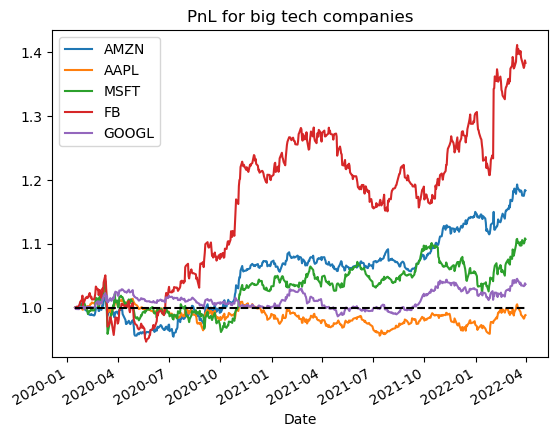

In [276]:
pnl_total = pd.Series(
    0,
    index = pnls["AAPL"].index
)
for k, pnl in pnls.items():
    # if k == "ADBE" or k == "ORCL":
    #     continue

    if k not in ["AAPL", "GOOGL", "FB", "AMZN", "MSFT"]:
        continue

    # if k != "NVDA":
        # continue

    pnl.add(1).cumprod().plot(
        label = k
    )


    pnl_total += pnl

# (pnl_total).add(1).cumprod().plot(
#     label = "total",
# )

plt.hlines(
    y = 1,
    xmin= pnl_total.index[0],
    xmax = pnl_total.index[-1],
    colors= "black",
    linestyles= "dashed"
)

plt.title("PnL for big tech companies")
plt.legend()

plt.savefig(f"img/strategy_total_{period}.png", bbox_inches = "tight" )



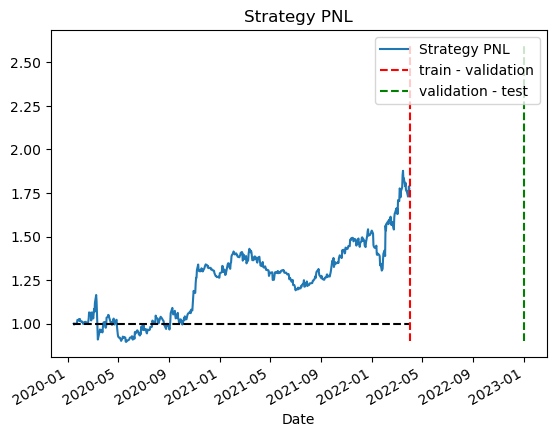

In [277]:
plt.title("Strategy PNL")

pnl_total\
    .add(1)\
    .cumprod()\
    .plot(
        label = "Strategy PNL"
    )

plt.hlines(
    y = 1,
    xmin= pnl_total.index[0],
    xmax = pnl_total.index[-1],
    colors= "black",
    linestyles= "dashed"
)

plt.vlines(
    x = pd.to_datetime("2022-04"),
    ymin = 0.9,
    ymax = 2.6,
    colors= "red",
    linestyles= "dashed",
    label = "train - validation"
)

plt.vlines(
    x = pd.to_datetime('2023-01'),
    ymin = 0.9,
    ymax = 2.6,
    colors= "green",
    linestyles= "dashed",
    label = "validation - test"
)

plt.legend()
plt.savefig(f"img/strategy_{period}.png", bbox_inches = "tight")



In [278]:
(pnl_total.mean())/pnl_total.std() * np.sqrt(252)

1.118060550974645

## Correlation with tech index

In [279]:
prices_df = yf.download(
    tickers= "SPG",
    start="2019-12-30",
    end="2023-12-30",
)

[*********************100%***********************]  1 of 1 completed


In [280]:
returns_etf = prices_df["Close"]\
    .pct_change()\
    .reindex(index= pnl_total.index)

In [281]:
returns_etf.mean()

0.0006962585800040753

In [282]:
pnl_total.diff().mean()

-1.0334732713370163e-05

In [283]:
(pnl_total - returns_etf).mean() / pnl_total.std() * np.sqrt(252)

0.4719591380610366

In [284]:
scaler = MinMaxScaler((0,1))
prices_close = scaler.fit_transform(prices_df[["Close"]])
# normalized_pnl = scaler.fit_transform(pd.DataFrame(pnl_total))

<Axes: xlabel='Date'>

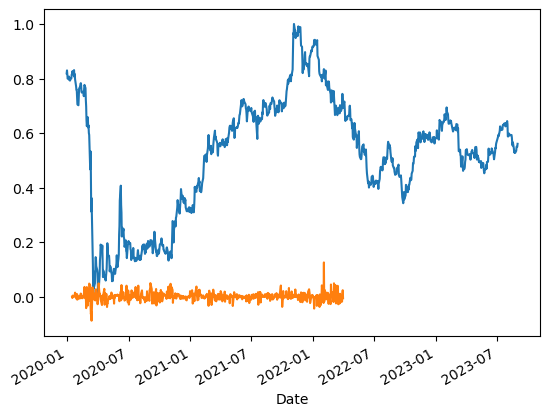

In [285]:
pd.Series(
    prices_close.reshape(-1),
    index = prices_df.index
).plot()
pnl_total.plot()

## Hypothesis test

In [300]:
from scipy.stats import norm

In [363]:
num_trades = {}

period = "full_period"
fees = 0

pnls = {}

for ticker in tqdm(universe):
    if ticker not in ["AMZN", "GOOGL", "AAPL", "MSFT", "FB"]:
        continue
    company_train = y_pred_train\
        .index\
        .get_level_values("ticker") == ticker


    company_test = y_pred_test\
        .index\
        .get_level_values("ticker") == ticker

    assert period in ["train", "val", "test", "full_period"], "period must be one of train, val, test, full_period"
    
    if period == "train":
        y_company = y_train[company_train]\
            .sort_index(level = "Date")
        y_pred_company = y_pred_train[company_train]\
            .sort_index(level = "Date")

    elif period == "full_period":
        y_company = pd.concat([
            y_train[company_train], 
            y_test[company_test]
        ])
        y_pred_company = pd.concat([
            y_pred_train[company_train],
            y_pred_test[company_test]
        ])
        
    else: 
        y_company = y_test[company_test]
        y_pred_company = y_pred_test[company_test]

        if period == "val":
            idx = y_company\
            .index\
            .get_level_values("Date") < "2023"
        
            y_company = y_company[idx]
            y_pred_company = y_pred_company[idx]

        else: # period == "test"
            idx = y_company\
            .index\
            .get_level_values("Date") > "2023"
        
            y_company = y_company[idx]
            y_pred_company = y_pred_company[idx]
        

    avg_price = y_pred_company\
        .pct_change()\
        .rolling(20)\
        .mean()

    std_price = y_pred_company\
        .pct_change()\
        .rolling(20)\
        .std()
    
    zscore = (y_pred_company.pct_change() - avg_price)/std_price

    positions = pd.Series(
        np.nan,
        index = y_pred_company.index,
        name = "position"
    )
    
    positions.loc[y_pred_company.pct_change() < 0]  = 1
    positions.loc[y_pred_company.pct_change() > 0] = -1 


    positions = positions\
        .fillna(0)
    
    num_long = (positions == 1).sum()/positions.shape[0]
    num_short = (positions == -1).sum()/positions.shape[0]
    mask = positions.rolling(2)\
        .sum() == 0
    trades = positions[mask]


    num_trades[ticker] = {
        "num_long" : num_long,
        "num_short" : num_short,
        "n_trades": trades.shape[0],
        "n_days" : positions.shape[0]
    }
    
    positions_df = pd.concat([y_company, positions], axis = 1)

    positions_df = positions_df\
        .reset_index(level = "ticker")

    pnl = pd.Series(
        0,
        index = positions_df.index,
        name = "pnl"
    )

    last_buy_price = np.nan
    cash = 0
    position = 0 

    returns = positions_df["price"]\
        .pct_change() * positions_df["position"].shift(1)
    # for date, row in positions_df.iterrows():
    #     first_trade = np.isnan(last_buy_price) and row["position"] != 0 
    #     has_position = not np.isnan(last_buy_price) and position != 0
    #     changing_position = has_position and row["position"] != position
    #     holding_position = has_position and row["position"] == position

    #     if (first_trade):
    #         last_buy_price = row["price"] * (1 + fees * position)
    #         position = row["position"]

    #     if (changing_position):
    #         cash += (row["price"] / last_buy_price - 1 )*position
    #         # last_buy_price = np.nan
    #         position = row["position"]
            
    #         if (position == 0):
    #             last_buy_price = np.nan
    #         else:
    #             last_buy_price = row["price"] * (1 + fees * position)

    #     if holding_position:
    #         pnl.loc[date] = (row["price"]- last_buy_price)/last_buy_price * position + cash

    #     else:
    #         pnl.loc[date] = cash

    # if row["position"] != 0:
    #     cash += (row["price"]- last_buy_price)/last_buy_price * position

    #     pnl.loc[date] = cash

    # returns = pnl.diff()

    pnls[ticker] = returns

100%|██████████| 10/10 [00:00<00:00, 102.98it/s]


In [364]:
pnl_total = pd.Series(
    0,
    index = pnls["AAPL"].index
)
for k, pnl in pnls.items():

    if k not in ["AAPL", "GOOGL", "FB", "AMZN", "MSFT"]:
        continue



    pnl_total += pnl

In [365]:
sr = pnl_total.mean() / pnl_total.std()

In [366]:
sr

0.0733944699515983

In [367]:
T = len(pnl_total)

gamma_3 = pnl_total.skew()
gamma_4 = pnl_total.kurtosis()

denominator =  1 - gamma_3 * sr + (gamma_4 - 1)/4 * sr**2
denominator = np.sqrt(denominator)

In [372]:
expected_sr = 0
psr = (sr - expected_sr) * np.sqrt(T - 1) / denominator
psr = norm.cdf(psr)

In [371]:
1- psr

29.22436792928274